In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Input, Multiply, Activation
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/PM10_sensor_and_council.csv')
data.head()

,Datetime,PM10_µg/m³_dust_pollen_mould_spores_sensor,PM10_µg/m³_council
0,2024-08-15 15:00:00,5.833333,17.0
1,2024-08-15 16:00:00,4.766667,14.8
2,2024-08-15 17:00:00,3.816667,18.1
3,2024-08-15 18:00:00,6.083333,14.4
4,2024-08-15 19:00:00,6.105263,0.3


In [3]:
X = data[['PM10_µg/m³_dust_pollen_mould_spores_sensor']].values
y = data['PM10_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[21.96610169],
       [10.35      ],
       [11.13333333],
       [ 9.33333333],
       [ 6.625     ]])

array([[ 1.24079012],
       [-0.00136591],
       [ 0.08239904],
       [-0.11008213],
       [-0.399695  ]])

array([[12.05      ],
       [ 7.        ],
       [ 4.66666667],
       [ 7.95      ],
       [ 8.        ]])

array([[ 0.18042186],
       [-0.35959476],
       [-0.60910739],
       [-0.25800747],
       [-0.25266077]])

In [7]:
def build_keras_model(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [8]:
def build_rnn_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(SimpleRNN(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(SimpleRNN(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [9]:
def build_gru_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(GRU(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(GRU(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [10]:
def build_lstm_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()

    for i in range(layers):
        if i == 0:
            model.add(LSTM(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(LSTM(units[i], return_sequences=False))
    
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [11]:
def build_keras_model_with_attention(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    
    attention = Dense(1, activation='tanh')(model.layers[-1].output)
    attention = Activation('softmax')(attention)
    attention = Multiply()([model.layers[-1].output, attention])
    
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [12]:
def build_rnn_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    rnn_out = inputs
    for i in range(layers):
        rnn_out = SimpleRNN(units[i], return_sequences=True if layers > 1 else False)(rnn_out)
    
    attention = Dense(1, activation='tanh')(rnn_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([rnn_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [13]:
def build_gru_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    gru_out = inputs
    for i in range(layers):
        gru_out = GRU(units[i], return_sequences=True if layers > 1 else False)(gru_out)
    
    attention = Dense(1, activation='tanh')(gru_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([gru_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [14]:
def build_lstm_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    lstm_out = inputs
    
    for i in range(layers):
        lstm_out = LSTM(units[i], return_sequences=True if layers > 1 else False)(lstm_out)
    
    attention = Dense(1, activation='tanh')(lstm_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([lstm_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

## Experimented List of Models and Parameters

#### The MLPRegressor: This model optimizes the squared error using LBFGS or stochastic gradient descent.
#### The KerasRegressor: Wrapper that enables Keras models so that they can be used as part of a Scikit-Learn workflow

In [15]:
models = {
    'MLP Regressor': MLPRegressor(random_state=42, verbose=0),
    'Keras Regressor': KerasRegressor(build_fn=build_keras_model, verbose=0),
    'RNN Regressor': KerasRegressor(build_fn=build_rnn_model, verbose=0),
    'GRU Regressor': KerasRegressor(build_fn=build_gru_model, verbose=0),
    'LSTM Regressor': KerasRegressor(build_fn=build_lstm_model, verbose=0),
    'MLP Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'Keras Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'RNN Regressor with Attention': KerasRegressor(build_fn=build_rnn_model_with_attention, verbose=0),
    'GRU Regressor with Attention': KerasRegressor(build_fn=build_gru_model_with_attention, verbose=0),
    'LSTM Regressor with Attention': KerasRegressor(build_fn=build_lstm_model_with_attention, verbose=0),
}

params = {
    'MLP Regressor': {
        'hidden_layer_sizes': [(50, 50), (100,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [200, 400],
    },
    'Keras Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'MLP Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'Keras Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    }
}

#### 1. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 2. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [16]:
best_models = []

best_score = float('inf')
best_params = None
best_model_name = ''

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    grid = GridSearchCV(estimator=model, param_grid=params[model_name], n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
    grid_result = grid.fit(X_train_scaled, y_train)
    
    try:
        best_models.append({
            'name': model_name,
            'model': grid_result.best_estimator_,
            'params': grid_result.best_params_,
            'rmse': -grid_result.best_score_
        })
    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training MLP Regressor...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Training Keras Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training MLP Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training Keras Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


#### For showcasing model with the best R2

In [17]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled) 
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

In [18]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: MLP Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 4.9582
Test MSE: 24.5841
Test R2: 0.3297
Test MAE: 3.5319


,Actual,Predicted
0,9.7,9.135036
1,11.2,9.856358
2,12.0,11.266607
3,8.7,9.475470
4,21.1,9.460714
5,5.2,10.482607
6,0.3,10.327733
7,12.5,9.160540
8,11.5,9.303403
9,14.4,10.341261


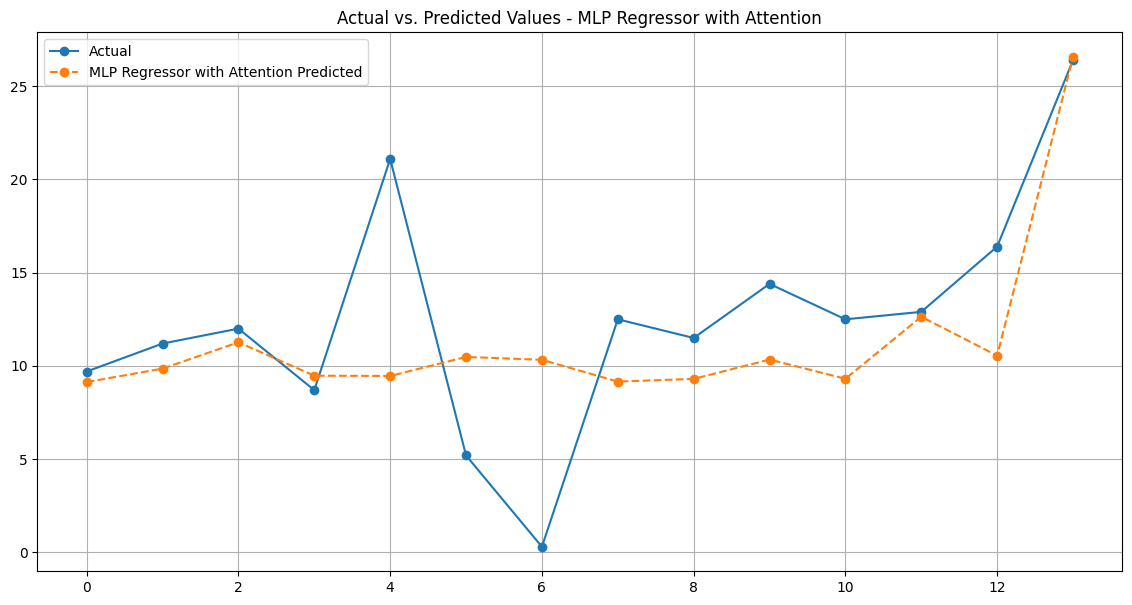


Results For Model: Keras Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 5.0552
Test MSE: 25.5554
Test R2: 0.3033
Test MAE: 3.7016


,Actual,Predicted
0,9.7,10.094139
1,11.2,10.200061
2,12.0,11.661410
3,8.7,9.699241
4,21.1,9.675211
5,5.2,11.428109
6,0.3,10.726688
7,12.5,9.498066
8,11.5,9.237886
9,14.4,10.740454


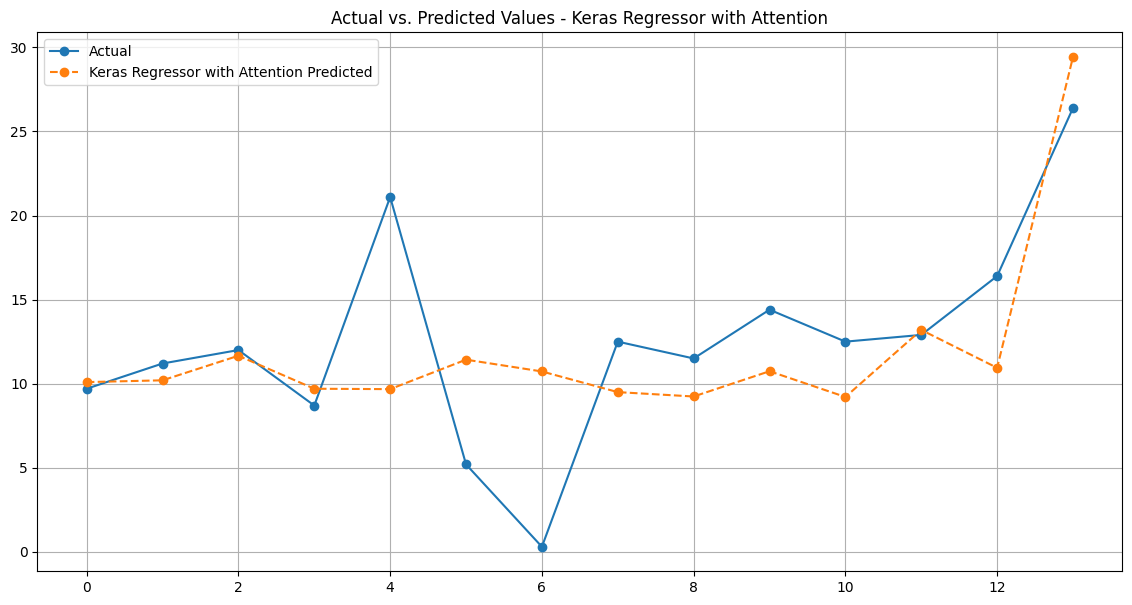


Results For Model: Keras Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 5.0967
Test MSE: 25.9762
Test R2: 0.2918
Test MAE: 3.7261


,Actual,Predicted
0,9.7,8.309295
1,11.2,9.837098
2,12.0,11.854609
3,8.7,9.123643
4,21.1,9.086095
5,5.2,9.857263
6,0.3,10.576601
7,12.5,8.340342
8,11.5,8.515358
9,14.4,10.595326


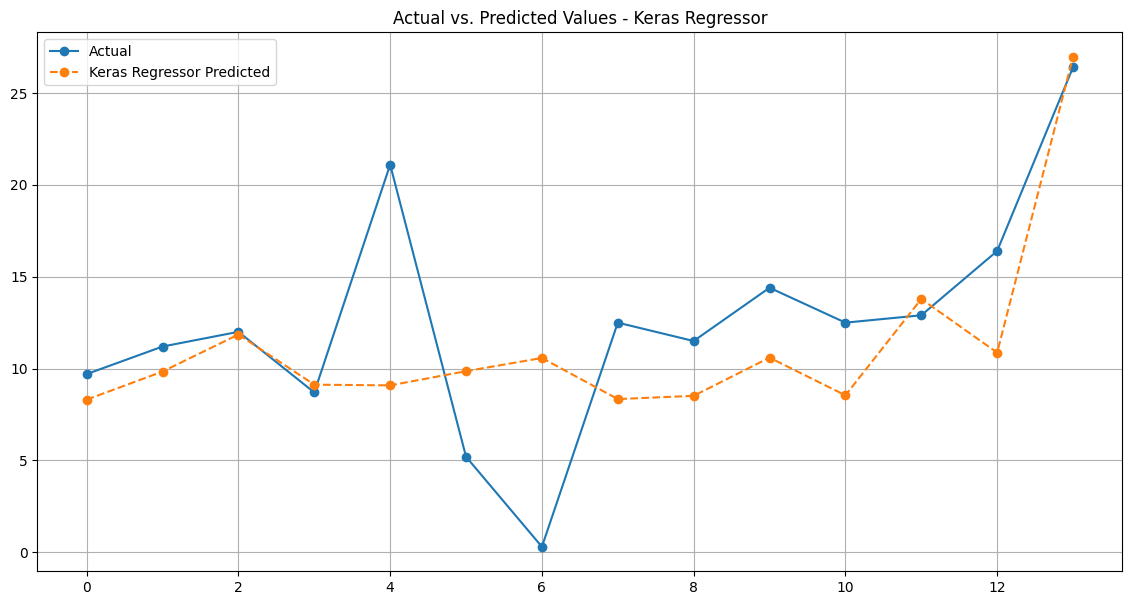


Results For Model: MLP Regressor
Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'sgd'}
Test RMSE: 5.7702
Test MSE: 33.2948
Test R2: 0.0923
Test MAE: 4.5620


,Actual,Predicted
0,9.7,15.636534
1,11.2,12.555355
2,12.0,11.367972
3,8.7,13.071211
4,21.1,13.099002
5,5.2,17.005215
6,0.3,12.088305
7,12.5,14.525338
8,11.5,13.957333
9,14.4,12.077059


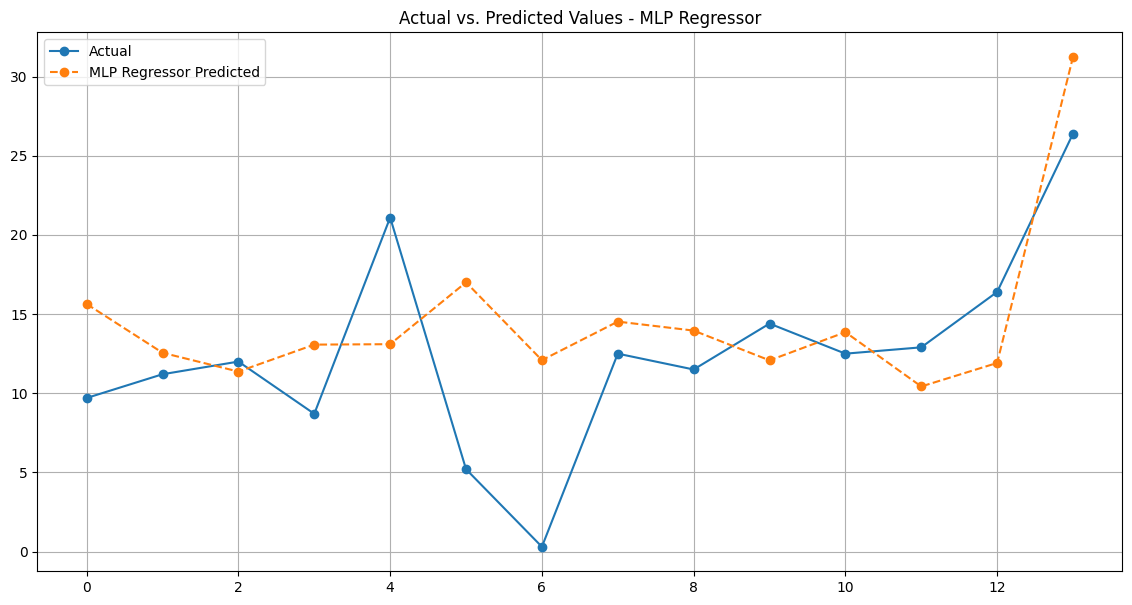


Results For Model: LSTM Regressor
Best Hyperparameters: {'batch_size': 20, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 5.8623
Test MSE: 34.3660
Test R2: 0.0630
Test MAE: 4.6702


,Actual,Predicted
0,9.7,16.239204
1,11.2,12.714834
2,12.0,11.224528
3,8.7,13.349347
4,21.1,13.383156
5,5.2,17.566813
6,0.3,12.131483
7,12.5,15.050003
8,11.5,14.403668
9,14.4,12.117366


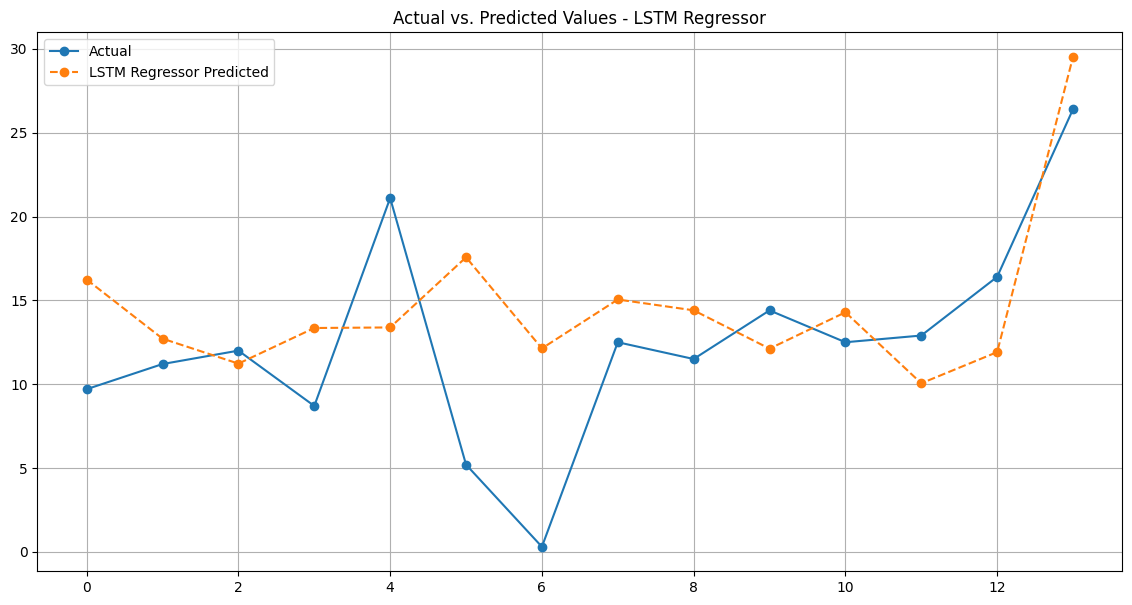


Results For Model: GRU Regressor
Best Hyperparameters: {'batch_size': 20, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 5.9961
Test MSE: 35.9527
Test R2: 0.0198
Test MAE: 4.8163


,Actual,Predicted
0,9.7,16.673735
1,11.2,12.820264
2,12.0,11.067827
3,8.7,13.542143
4,21.1,13.580227
5,5.2,18.038473
6,0.3,12.144204
7,12.5,15.413847
8,11.5,14.712765
9,14.4,12.127689


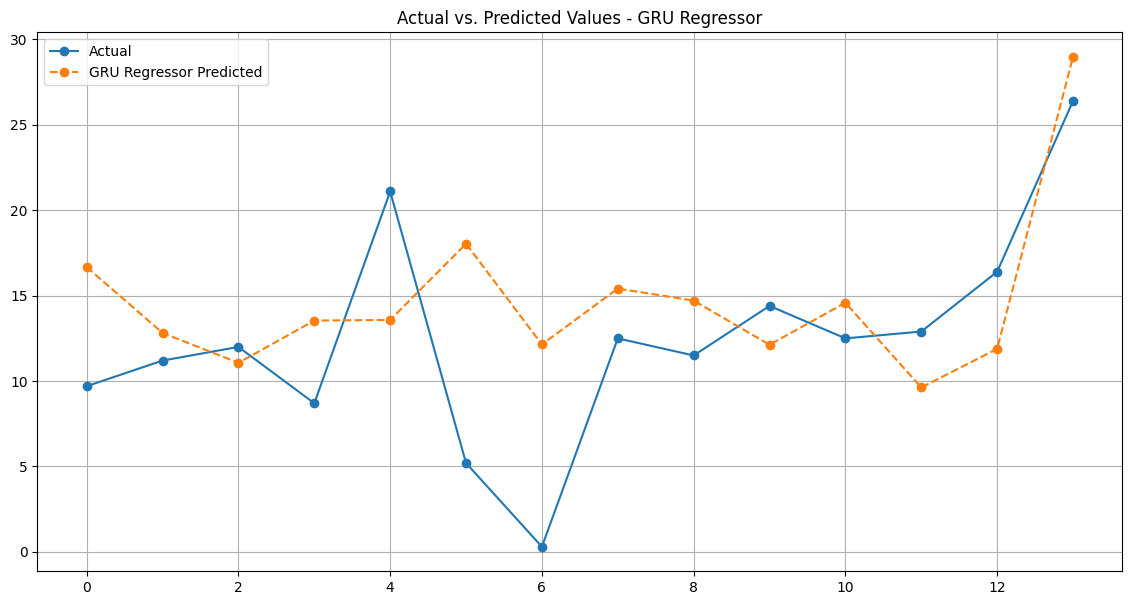


Results For Model: LSTM Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 6.2176
Test MSE: 38.6588
Test R2: -0.0540
Test MAE: 4.8691


,Actual,Predicted
0,9.7,14.784539
1,11.2,14.529166
2,12.0,14.455710
3,8.7,14.567430
4,21.1,14.569574
5,5.2,14.904199
6,0.3,14.497514
7,12.5,14.687410
8,11.5,14.639014
9,14.4,14.496794


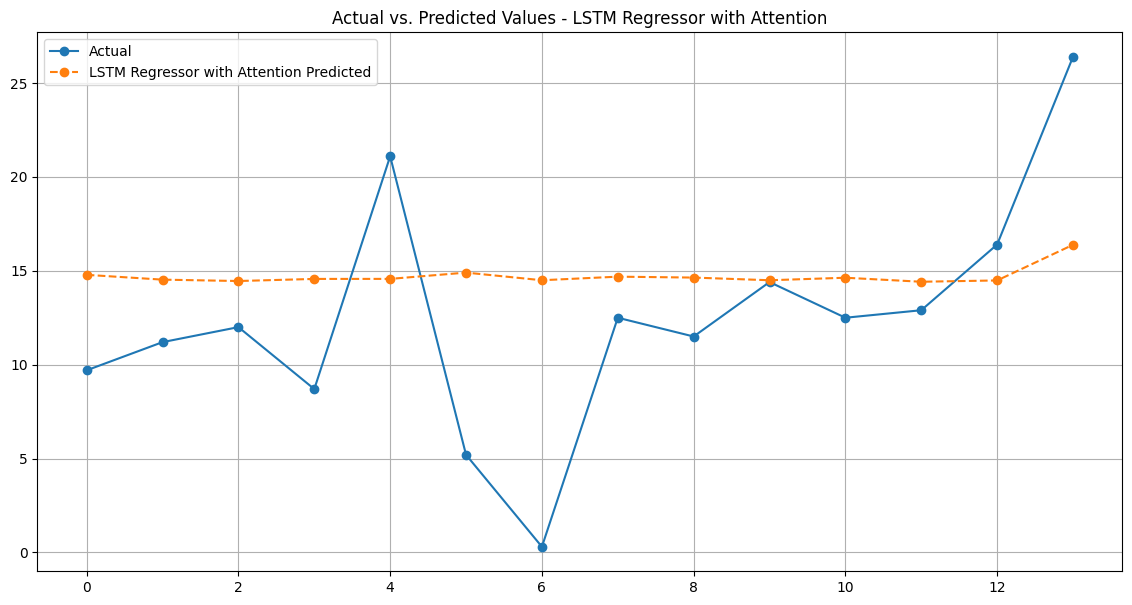


Results For Model: RNN Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 6.3561
Test MSE: 40.4004
Test R2: -0.1015
Test MAE: 5.0127


,Actual,Predicted
0,9.7,15.570939
1,11.2,14.693622
2,12.0,14.160924
3,8.7,14.885790
4,21.1,14.895530
5,5.2,15.807483
6,0.3,14.499842
7,12.5,15.321522
8,11.5,15.168130
9,14.4,14.494932


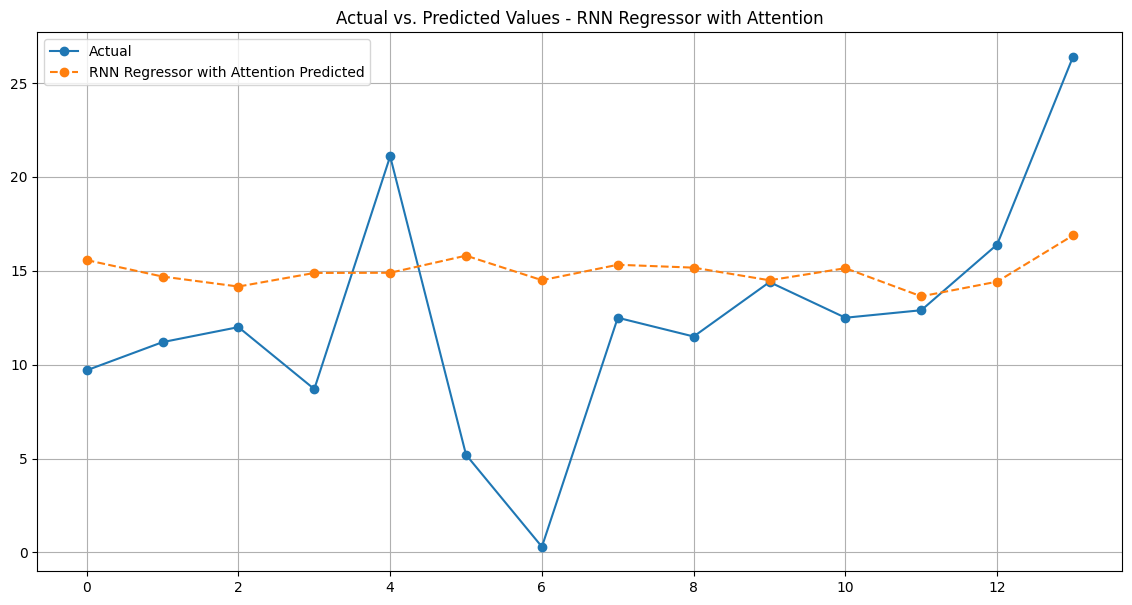


Results For Model: GRU Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 6.3600
Test MSE: 40.4497
Test R2: -0.1028
Test MAE: 5.0289


,Actual,Predicted
0,9.7,15.136367
1,11.2,14.737772
2,12.0,14.539967
3,8.7,14.815945
4,21.1,14.820024
5,5.2,15.267892
6,0.3,14.662873
7,12.5,15.010824
8,11.5,14.939075
9,14.4,14.661017


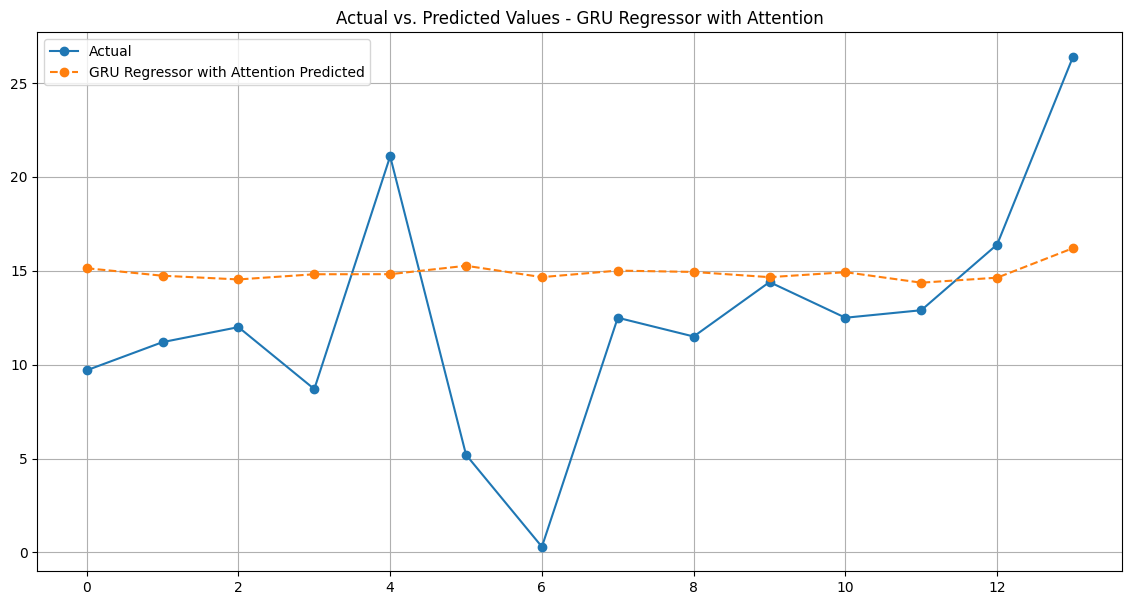


Results For Model: RNN Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 6.3604
Test MSE: 40.4552
Test R2: -0.1030
Test MAE: 4.9523


,Actual,Predicted
0,9.7,17.653017
1,11.2,13.931991
2,12.0,12.088686
3,8.7,14.661769
4,21.1,14.699821
5,5.2,18.877819
6,0.3,13.233328
7,12.5,16.481689
8,11.5,15.811684
9,14.4,13.216072


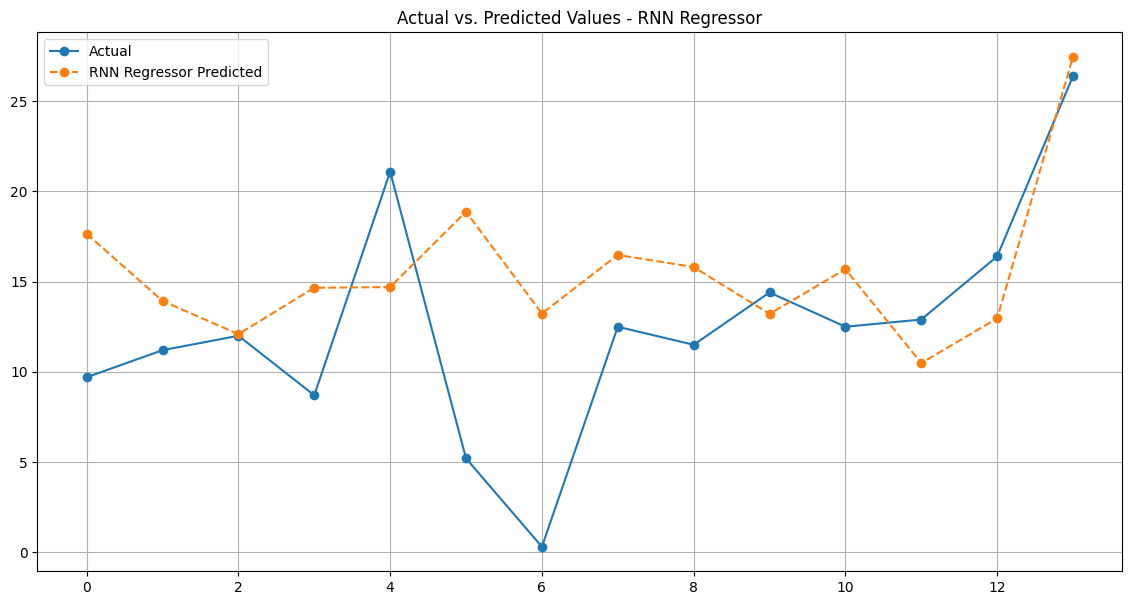

In [19]:
for result in results:
    model_name = result['name']
    print(f"Results For Model: {model_name}")
    print(f"Best Hyperparameters: {result['params']}")
    print(f"Test RMSE: {result['rmse']:.4f}")
    print(f"Test MSE: {result['mse']:.4f}")
    print(f"Test R2: {result['r2']:.4f}")
    print(f"Test MAE: {result['mae']:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [20]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,MLP Regressor with Attention,4.958231,24.584056,0.329740,3.531876
1,Keras Regressor with Attention,5.055237,25.555416,0.303256,3.701561
2,Keras Regressor,5.096681,25.976159,0.291785,3.726096
3,MLP Regressor,5.770163,33.294783,0.092250,4.561953
4,LSTM Regressor,5.862252,34.366004,0.063044,4.670151
5,GRU Regressor,5.996057,35.952703,0.019785,4.816349
6,LSTM Regressor with Attention,6.217619,38.658786,-0.053994,4.869139
7,RNN Regressor with Attention,6.356135,40.400448,-0.101479,5.012681
8,GRU Regressor with Attention,6.360006,40.449681,-0.102821,5.028939
9,RNN Regressor,6.360441,40.455207,-0.102972,4.952270
